# Determining site suitability for oil palm plantation 

## Table of Contents

- [Introduction](#introduction)
- [Prerequisites](#prerequisites)
- [Necessary Imports](#imports)
- [Using Raster Function Template ](#rft)
    - [Suitability factors taken into consideration in the RFT](#factors)
    - [Uploading the RFT to ArcGIS Online using Content Manager](#upload)
    - [Creating the RFT object using the RFT class from raster function template item. ](#create)
- [Creating hosted imagery layers for analysis](#layers)
- [Applying the raster function chain on the input layers to create the suitability raster ](#suitability)
    - [Persisting the output in the GIS](#op)
- [Conclusion](#conclusion)
- [References](#references)

## Introduction <a class= 'anchor' id='introduction'></a> 

Proper land suitability assessment for agriculture has to be carried out to determine the potentiality of a land area to provide the most favorable ecological requirements for a particular crop variety, which results in optimum crop development and maximum productivity. 

In this notebook, we determine the site suitability for oil palm development by: 
 
 - Creating hosted imagery layers. 
 - Applying raster function chain using the RFT class from the arcgis.raster.functions module.
 - Persisting the raster analysis in ArcGIS Online.
 
Note: This analysis can be conducted on ArcGIS Enterprise as well as on ArcGIS Online. In this notebook, the notebook was carried out using ArcGIS Online.

## Prerequisites<a class= 'anchor' id='prerequisites'></a> 

- To run raster analysis functions on ArcGIS Online, you must have privileges to create and publish content and to perform Raster Analysis.
For more information, refer [here](https://doc.arcgis.com/en/arcgis-online/analyze/perform-raster-analysis.htm).<br>

- For creating imagery layers using [copy_raster](https://developers.arcgis.com/python/api-reference/arcgis.raster.analytics.html#copy-raster) in ArcGIS Online, Azure library packages for Python (Azure SDK for Python - azure-storage-blob: 12.1<= version <=12.8) needs to be pre-installed. Refer https://docs.microsoft.com/en-us/azure/developer/python/azure-sdk-install

- An optional installation of graphviz 2.38 can be used to visualize the funciton chain of the raster function template.  

## Necessary Imports <a class= 'anchor' id='imports'></a> 

In [1]:
import os
import zipfile

import arcgis
from arcgis.gis import GIS
from arcgis.raster.analytics import copy_raster
from arcgis.raster.functions import RFT

In [2]:
gis = GIS("Home")

## Using Raster Function Template (RFT)<a class= 'anchor' id='rft'></a> 

A raster function template is a model that consists of many function chains to produce a processing workflow. We can build the RFT using the function editor and raster functions pane.

The RFT can be created using [ArcGIS Pro](https://pro.arcgis.com/en/pro-app/latest/help/analysis/raster-functions/raster-function-template.htm) or [ArcGIS Enterprise](https://enterprise.arcgis.com/en/portal/latest/use/raster-function-editor.htm). 

###  Suitability factors taken into consideration in the RFT <a class= 'anchor' id='factors'></a> 

In order to carry out the suitability analysis, we need to consider some of the favorable environmental and crop criteria settings:

| Suitability  Considerations | Suitable | Not suitable |
| --- | --- | --- |
| Elevation |  0-1000m | >1000 m |
| Slope | 0-30% | >30% |
| Conservation area buffer | >1000 m | <1000m |
| Soil type | Inceptisol, Oxisol, Alfisol, Ultisol, Spodosol, Entisol | Histosols |
| Soil acidity | 1-7 | None |



Based on these criteria, a raster function template was created using ArcGIS Pro. You can acquire the RFT using the following item. 

In [32]:
palm_oil_suitability_rft = gis.content.get('9fa702ab04f747be99607206c2d0eaaa')
palm_oil_suitability_rft

<Item title:"PalmOilSuitability_UsingFiveFactors" type:Raster function template owner:api_data_owner>

The RFT can be further added to your own GIS for further analysis, by downloading the RFT and adding it to your GIS. 

In [33]:
# assign variables to locations on the file system 
cwd = os.path.abspath(os.getcwd())
data_path = os.path.join(cwd, r'data')

In [34]:
rft_path = palm_oil_suitability_rft.download(save_path=data_path)

### Uploading the RFT to ArcGIS Online using Content Manager <a class= 'anchor' id='upload'></a> 

In [3]:
palm_oil_suitability_rft_item=gis.content.add(item_properties={"type":"Raster function template",
                                                          "title":"PalmOilSuitability",
                                                          "tags":"PalmOilSuitability_UsingFiveFactors"
                                                         },
                                              data=rft_path
                                              )

### Creating the RFT object using the RFT class from raster function template item. <a class= 'anchor' id='create'></a> 

In [4]:
palm_oil_suitability_rft = RFT(palm_oil_suitability_rft_item, gis=gis)

We can visualize the function chain and help document specific to this RFT in order to understand the input parameters and the functions involved.


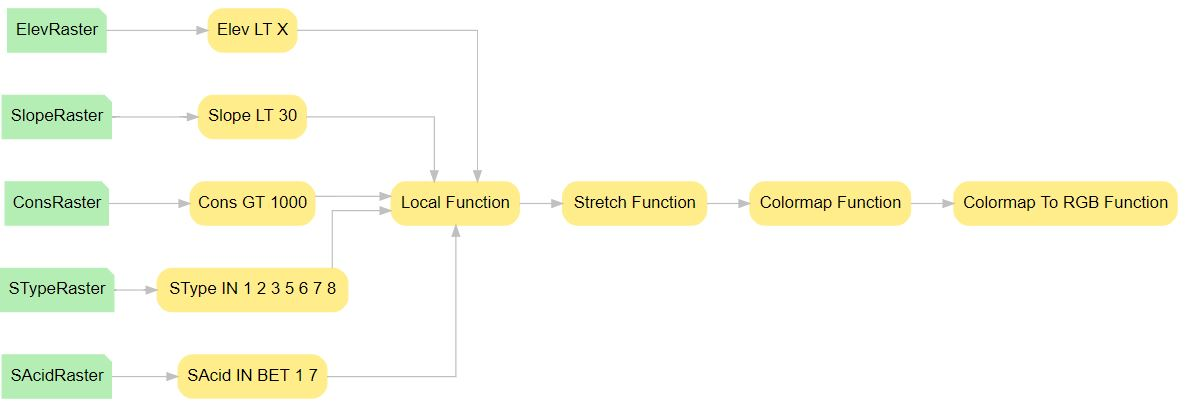

In [2]:
palm_oil_suitability_rft.draw_graph(graph_size='10, 15')

A '?' before or after an RFT object will display the help document consisting of the parameters marked as public by the author of the RFT.

In [12]:
palm_oil_suitability_rft?

"""
A raster function template to determine the site suitability for oil palm development.

Parameters
----------

ElevRaster : None
SlopeRaster : None
ConsRaster : None
STypeRaster : None
SAcidRaster : None

Returns
-------
Imagery Layer, on which the function chain is applied 
"""


## Creating hosted imagery layers for analysis <a class= 'anchor' id='layers'></a> 

Hosted imagery layers can be used to manage, share, and analyze raster and imagery data. Hosted imagery layers can be used as an input to analysis tools, create custom workflows with raster functions, manage large collections of imagery, and include imagery layers in maps. 

The [copy_raster](https://developers.arcgis.com/python/api-reference/arcgis.raster.analytics.html#copy-raster) function is used here to create hosted imagery layers in ArcGIS Online from local raster datasets.

In the following cells, we will be creating hosted layers representing the elevation, conservation area buffer, slope, soil type and soil acidity. They will act as the input rasters to the RFT. 

You can acquire the data for analysis by using the following item.

In [43]:
analysis_data = gis.content.get('40b00dc5c8794059811d0cced66e9113')
analysis_data

<Item title:"site_suitability_for_oil_palm_plantation_data" type:Image Collection owner:api_data_owner>

In [65]:
#downloading the data
analysis_data_path = analysis_data.download(save_path=data_path)
with zipfile.ZipFile(analysis_data_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

In [5]:
elevation_wm_data_path = os.path.join(os.path.splitext(analysis_data_path)[0], r'elevation_wm')
elevation_wm_item = copy_raster(input_raster=elevation_wm_data_path,
                                output_name="elevation_palm_tiled",
                                raster_type_name="Raster Dataset",
                                tiles_only=True
                               )
elevation_wm_layer = elevation_wm_item.layers[0]


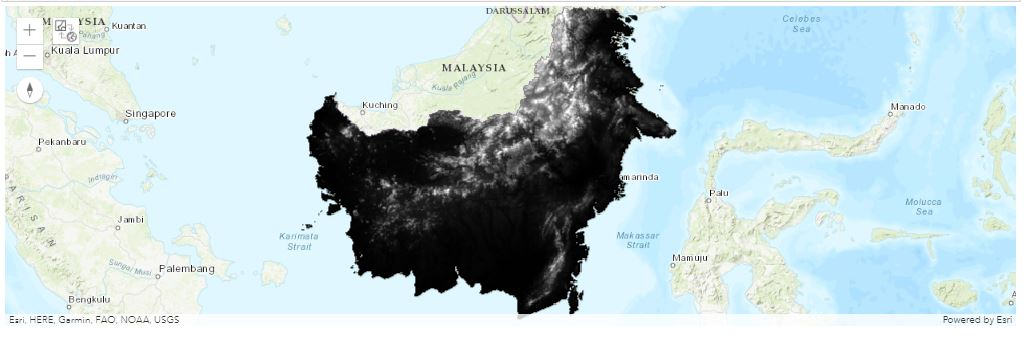

In [4]:
mp = gis.map()
mp.extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmax': 13940786.084357359,
 'xmin': 11533936.937714368,
 'ymax': 495805.2734337793,
 'ymin': -482588.6886162166}
mp.add_layer(elevation_wm_layer)
mp

In [6]:
conser_wm_data_path = os.path.join(os.path.splitext(analysis_data_path)[0], r'conser_wm')
conser_wm_item = copy_raster(input_raster=conser_wm_data_path,
                             output_name="conser_palm_tiled", 
                             raster_type_name="Raster Dataset", 
                             tiles_only=True
                            )
conser_wm_layer = conser_wm_item.layers[0]


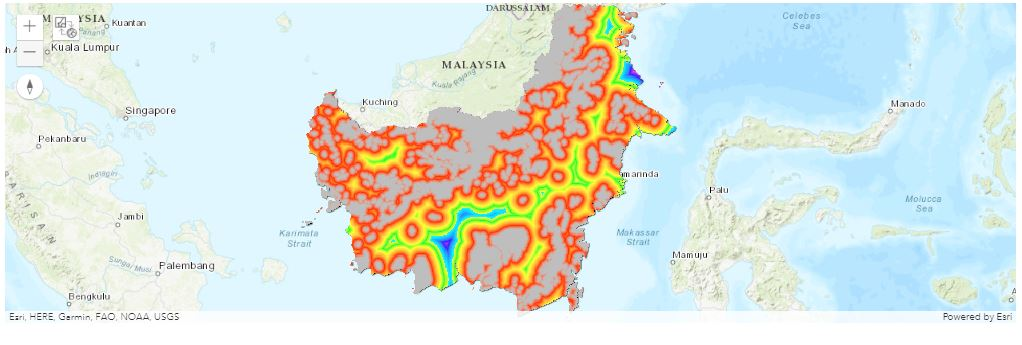

In [5]:
mp.add_layer(conser_wm_layer)
mp

In [28]:
slope_wm_path = os.path.join(os.path.splitext(analysis_data_path)[0], r'slope_wm')
slope_wm_item = copy_raster(input_raster=slope_wm_path,
                            output_name="slope_palm_tiled", 
                            raster_type_name="Raster Dataset",
                            tiles_only=True
                           )
slope_wm_layer = slope_wm_item.layers[0]


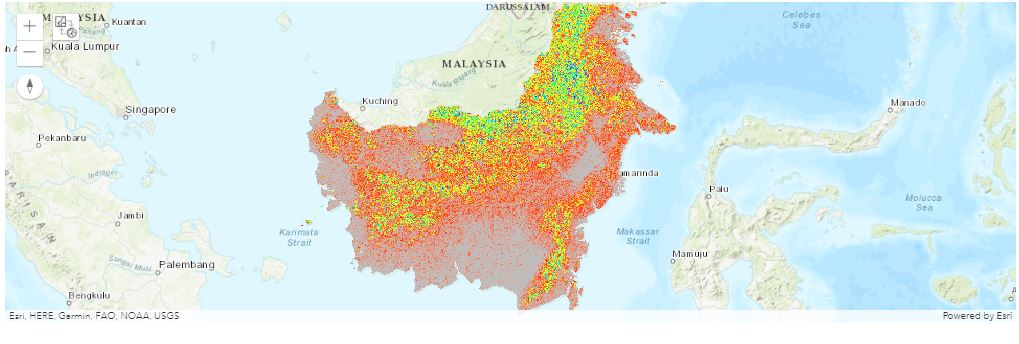

In [7]:
mp.add_layer(slope_wm_layer)
mp

In [30]:
soil_acid_wm_path = os.path.join(os.path.splitext(analysis_data_path)[0], r'soil_acid_wm')
soil_acid_wm_item = copy_raster(input_raster=soil_acid_wm_path,
                                output_name="soil_acid_palm_tiled",
                                raster_type_name="Raster Dataset",
                                tiles_only=True
                               )
soil_acid_wm_layer = soil_acid_wm_item.layers[0]


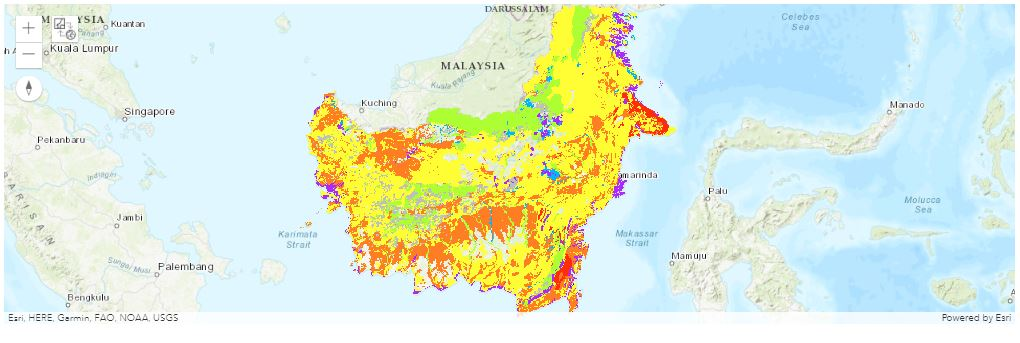

In [8]:
mp.add_layer(soil_acid_wm_layer)
mp

In [32]:
soil_type_wm_path = os.path.join(os.path.splitext(analysis_data_path)[0], r'soil_type_wm')
soil_type_wm_item = copy_raster(input_raster=soil_type_wm_path,
                                output_name="soil_type_palm_tiled",
                                raster_type_name="Raster Dataset",
                                tiles_only=True
                               )
soil_type_wm_layer = soil_type_wm_item.layers[0]


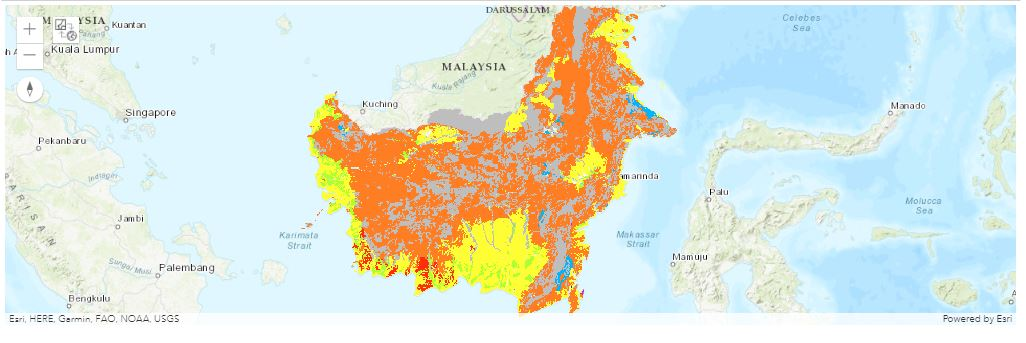

In [9]:
mp.add_layer(soil_type_wm_layer)
mp

## Applying the raster function chain on the input layers to create the suitability raster <a class= 'anchor' id='suitability'></a> 

In [32]:
suitability_output = palm_oil_suitability_rft(ElevRaster=elevation_wm_layer,
                                              SlopeRaster=slope_wm_layer , 
                                              ConsRaster=conser_wm_layer, 
                                              STypeRaster=soil_type_wm_layer, 
                                              SAcidRaster=soil_acid_wm_layer
                                             )

### Persisting the output in the GIS<a class= 'anchor' id='op'></a> 

In [35]:
saved_output = suitability_output.save(output_name='palm_oil_suitability_saved_til', tiles_only=True)


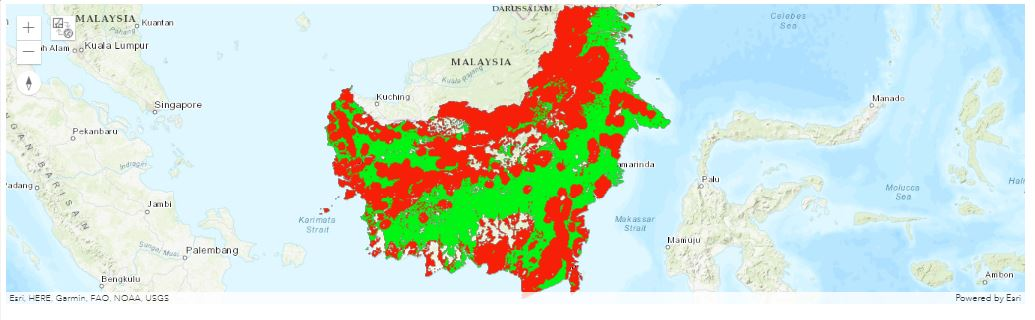

In [12]:
mp.add_layer(saved_output.layers[0])
mp

In the output, the red areas denote places that are less suitable for oil palm plantation, while green areas represent places that are more suitable.

## Conclusion <a class= 'anchor' id='conclusion'></a> 

In this notebook, we located potentially suitable areas for sustainable oil palm cultivation. This analysis can act as a first step in a site selection process for a certified sustainable plantation and can inform government officials and nongovernmental organizations (NGOs) in assessing land use policy options to support the expansion of sustainable palm oil production.

## References <a class= 'anchor' id='references'></a> 

[1] [https://hub.arcgis.com/datasets/afe7ce49f19941fab8db58e2aab90910 ]